Fold 1 Accuracy Score: 0.96
Fold 2 Accuracy Score: 0.96
Fold 3 Accuracy Score: 0.96
Fold 4 Accuracy Score: 0.93
Fold 5 Accuracy Score: 0.95


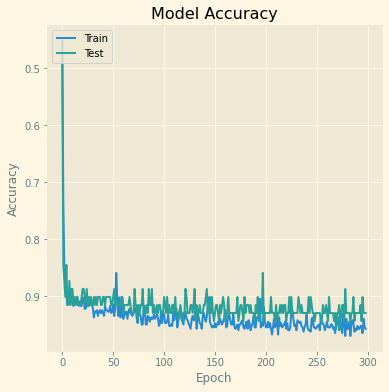


Epochs: 300
Width: 3
Kfolds: 5
First fold test accuracy: 0.936, Second fold test accuracy: 0.934
Third fold test accuracy: 0.933, Fourth fold test accuracy: 0.931
Fifth fold test accuracy: 0.937

The Model Accuracy graph displays how accurate the training and test set
    are behaving through each epoch. You can see the model is getting more and more accurate
    the more we train, with the model eventually leveling off around iterations. This gives us an average
    accuracy of about ~ 94%.This specific model shows a hidden layer width of 3 and an epoch 
    of 300 which allows for a very accurate model.

In the current graph, there are some instances of overfitting and underfitting when you see the dips
 in the test data, but overall this is a fairly good model. However, when the hidden layer width is reduced
 or increased is when we can really see instances of overfitting within our model.
    


In [8]:
!pip install fpdf

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from fpdf import FPDF

warnings.filterwarnings('ignore')

class BreastCancer:

  def __init__(self, file, hidden_layers, epochs, kfolds):
    self.file = file
    self.hidden_layers = hidden_layers
    self.data = pd.read_csv(self.file, header = None)
    self.accuracys = list()
    self.model_history = None
    self.epochs = epochs
    self.kfolds = kfolds
    self.format_data()
    self.prediction()
    self.plot()
    self.to_pdf()

  """
  Function that to ouput a pdf report of 
  the mlp findings
  """
  def to_pdf(self):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=26)
    pdf.cell(200, 10, txt="Breast Cancer MLP Model Report", ln=1, align="C")
    
    pdf.set_font("Arial", size=26)
    pdf.cell(200,10, txt="\nSummary", align="C")

    pdf.set_font("Arial", size=12)
    pdf.multi_cell(200, 10, txt="hi", align="L")


    summary_text = """\nEpochs: {}\nWidth: {}\nKfolds: {}\nFirst fold test accuracy: {}, Second fold test accuracy: {}\nThird fold test accuracy: {}, Fourth fold test accuracy: {}\nFifth fold test accuracy: {}\n\nThe Model Accuracy graph displays how accurate the training and test set
    are behaving through each epoch. You can see the model is getting more and more accurate
    the more we train, with the model eventually leveling off around iterations. This gives us an average
    accuracy of about ~ 94%.This specific model shows a hidden layer width of 3 and an epoch 
    of 300 which allows for a very accurate model.\n\nIn the current graph, there are some instances of overfitting and underfitting when you see the dips\n in the test data, but overall this is a fairly good model. However, when the hidden layer width is reduced\n or increased is when we can really see instances of overfitting within our model.
    """.format(self.epochs, self.hidden_layers, self.kfolds, self.accuracys[0], self.accuracys[1], self.accuracys[2], self.accuracys[3], self.accuracys[4])
    print(summary_text)
    pdf.set_font("Arial", size=12)
    pdf.multi_cell(200, 5, txt=summary_text, align="L")
    pdf.image('model accuracy.png')
    pdf.output("report.pdf")

  """
  Function that takes the MLP data and
  plots the learning curve
  """
  def plot(self):
    plt.style.use('Solarize_Light2')
    plt.figure(figsize=(6,6))
    plt.plot(self.model_history.history['accuracy'])
    plt.plot(self.model_history.history['val_accuracy'])
    plt.gca().invert_yaxis()
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig("model accuracy.png")
    plt.show()


  
  """
  Function that formats the given data.
  Add appropriate column names, remove the id column, and 
  map the diagnosis
  """
  def format_data(self):
    self.data.columns = ['id','diagnosis','radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean',
              'compactness_mean','concavity_mean','concave_points_mean','symmetry_mean','fractal_dimension_mean',
              'radius_se','texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se',
              'concave_points_se','symmetry_se','fractal_dimension_se','radius_worst','texture_worst',
              'perimeter_worst','area_worst','smoothness_worst','compactness_worst','concavity_worst',
              'concave_points_worst','symmetry_worst','fractal_dimension_worst']
    self.data.drop(['id'], axis=1, inplace=True)
    self.data['diagnosis'] = self.data['diagnosis'].map({'M': 0, 'B': 1})

    cols = list(self.data.columns.values) 
    cols.pop(cols.index('diagnosis')) 
    self.data = self.data[cols + ['diagnosis']]

  """
  Function that creates our mlp model
  """
  def prediction(self):
    #Parse X and Y, get the training and test values
    X = self.data.iloc[:, :-1].values
    Y = self.data.iloc[:, 30].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.175, random_state = 0)
    
    #Initialize our dummy classifier
    dummy = DummyClassifier()
    dummy.fit(X_train, Y_train)

    y_pred = dummy.predict(X_test)
    kfold = KFold(n_splits=self.kfolds, shuffle=True)
    
    #Run kfold iterations 
    fold_no = 1
    for i, j in kfold.split(X_train, Y_train):
      model = Sequential()
      #Add n hidden layers and increase the rate for each layer
      rate = 0.1
      for layer in range(0, self.hidden_layers):
        model.add(Dense(units = 30, activation = 'relu', kernel_initializer = 'uniform', input_dim = 30))
        model.add(Dropout(rate))
        rate += 0.05

      #Final output layer for our model
      model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer = 'uniform'))
      model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) 
      

      #Get the prediction accuracy
      fit = model.fit(X_train, Y_train, batch_size = 16, epochs = self.epochs, validation_split = 0.15, verbose=0)
      predict = model.predict(X_test) > 0.5
      predic_acc = accuracy_score(Y_test, predict)
      acc = round(sum(fit.history['accuracy']) / len(fit.history['accuracy']), 3)
      self.accuracys.append(acc)
      self.model_history = fit
      print('Fold {} Accuracy Score: {}'.format(fold_no, str(predic_acc)))
      fold_no += 1


if __name__ == "__main__":
  file = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
  BreastCancer(file = file, hidden_layers = 3, epochs = 300, kfolds=5)
